In [ ]:

from sys import argv
import pyreadr
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
from scipy import stats

from sklearn.base import clone
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

#from missingpy import KNNImputer,MissForest


def rmse_loss(ori_data, imputed_data, data_m=None):  
    normin,normax = get_rescale(ori_data)
    ori = set_rescale(ori_data,normin,normax)
    imp = set_rescale(imputed_data,normin,normax)
    
    deltas = ( ori - imp)**2
    if not data_m is None:
        deltas = deltas[data_m]
    return np.sqrt(  np.mean(deltas)  )

# dffinal_repeat_select_widformat_t0_1st.RData
# dffinal_repeat_select_widformat_t0_masked_1st.RData

# dffinal_repeat_select_widformat_t1_1st.RData
# dffinal_repeat_select_widformat_t1_masked_1st.RData

def data_load(prefix='data/',i=0,part = '1st'):

    frame = {'data':[],'masked':[]}
    template = 'dffinal_repeat_select_widformat_t{}_{}{}.RData'
    for typ in ['','masked_']:
        fname = template.format(i,typ,part)
        result = pyreadr.read_r(prefix+fname)
        key = list(result.keys())[0]
        if typ=='':
            frame['data'] = result[key]
        else:
            frame['masked'] = result[key]

    return frame

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

def annotate_colname(x, **kws):
    print(type(x))
    ax = plt.gca()
    ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

def cor_matrix(df):
    g = sns.PairGrid(df, palette=['red'])
    # Use normal regplot as `lowess=True` doesn't provide CIs.
    g.map_upper(sns.regplot, scatter_kws={'s':10})
    g.map_diag(sns.distplot)
    g.map_diag(annotate_colname)
    g.map_lower(sns.kdeplot, cmap='Blues_d')
    g.map_lower(corrfunc)
    # Remove axis labels, as they're in the diagonals.
    for ax in g.axes.flatten():
        ax.set_ylabel('')
        ax.set_xlabel('')
    return g

def get_rescale(xx):
    normin = xx.min(axis=0,keepdims=1)
    normax = xx.max(axis=0,keepdims=1)
    return normin,normax
    
def set_rescale(xx,normin,normax):
    xx = (xx-normin)/(normax-normin)
#     xx = xx/normax
    return xx

def pdf(m,bins=30,normed=None):
    m = np.array(m)
    hist, bin_edges = np.histogram(m, bins, density=normed)
    bins = 0.5*(bin_edges[1:]+bin_edges[:-1])
    return bins,hist

# analyze before or after

In [ ]:
!mkdir res5

In [ ]:
i = int(argv[1]) # can be 0 or 1
j = argv[2] #'1st' #,'2nd','3rd'
k = int(argv[3]) # can be sellected based on the below dictionary
# i2name = {0:'mean',1:'median',2:'BayesianRidge',3:'DecisionTreeRegressor',
#           4:'RandomForestRegressor',5:'MLPRegressor',6:'ExtraTreesRegressor',
#           7:'KNeighborsRegressor',8:'XGBModel'}

prefix = 'res5/{}-{}-{}-'.format(i,j,k)

frame = data_load(prefix='data/',i=i,part = j)

#fig,ax = plt.subplots(1,1,figsize=(18,4))
#xx = np.isnan(frame['masked']).values.T
#ax.imshow(xx,aspect='auto',cmap='gray',interpolation='none')

good_data = frame['data'].drop(columns=['PT_ID']).values#[:500,:]
bad_data = frame['masked'].drop(columns=['PT_ID']).values#[:500,:]

#missed = np.isnan(bad_data)#.astype(int)
#bad_data[missed] = np.nan
#ncol = good_data.shape[1]

missed = np.isnan(bad_data)#.astype(int)
filt = np.mean(missed,axis=1)!=1
good_data = good_data[filt]
bad_data = bad_data[filt]
missed = missed[filt]
bad_data[missed] = np.nan
ncol = good_data.shape[1]
print(good_data.shape,bad_data.shape)

normin,normax = get_rescale(good_data)
ress = {}
y_preds = {}

labels = list(frame['data'].columns)[1:]

if k==0:
    from sklearn.impute import SimpleImputer
    strategy = 'mean'
    si = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputed_data = si.fit_transform(bad_data)
    imputed_data[~missed] = good_data[~missed]
    y_true = good_data[missed]
    y_pred = imputed_data[missed]
elif k==1:
    from sklearn.impute import SimpleImputer
    strategy = 'median'
    si = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputed_data = si.fit_transform(bad_data)
    imputed_data[~missed] = good_data[~missed]
    y_true = good_data[missed]
    y_pred = imputed_data[missed]

elif k==2:
    from sklearn.linear_model import BayesianRidge
    impute_estimator0 = BayesianRidge()
elif k==3:
    from sklearn.tree import DecisionTreeRegressor
    impute_estimator0 = DecisionTreeRegressor(max_features='sqrt', random_state=0)
elif k==4:
    from sklearn.ensemble import RandomForestRegressor
    impute_estimator0 = RandomForestRegressor(n_estimators=100, n_jobs=-1)
elif k==5:
    from sklearn.neural_network import MLPRegressor
    impute_estimator0 = MLPRegressor()
elif k==6:
    from sklearn.ensemble import ExtraTreesRegressor
    impute_estimator0 = ExtraTreesRegressor(n_estimators=10, random_state=0,n_jobs=-1)
elif k==7:
    from sklearn.neighbors import KNeighborsRegressor
    impute_estimator0 = KNeighborsRegressor(n_neighbors=15)
elif k==8:
    from xgboost import XGBModel
    impute_estimator0 = XGBModel(n_jobs=-1)
else:
    assert 0, 'Unknown regressor!'

if k>1:
    impute_estimator = clone(impute_estimator0)
    imputer = IterativeImputer(random_state=0,
                               missing_values=np.nan,
                               estimator=impute_estimator,
                               max_iter=50,verbose=1)
    imputed_data = imputer.fit_transform(bad_data)
    y_true = good_data[missed]
    y_pred = imputed_data[missed]

print(r2_score(y_true, y_pred))
print(rmse_loss(y_true, y_pred))

np.save(prefix+'res',[r2_score(y_true, y_pred),rmse_loss(y_true, y_pred)])
np.save(prefix+'imputed',imputed_data)

fig, axs = plt.subplots(9,5,figsize=(13,20))
for icol in range(ncol):
    gdata = good_data[:,icol]
    idata = imputed_data[:,icol]
    mmask = missed[:,icol]
    
    y_true = gdata[mmask]
    y_pred = idata[mmask]
    
    # Plotting the KDE Plot 
    sns.kdeplot(y_true, color='b', shade=True, ax=axs[icol%9,icol//9]) 
    sns.kdeplot(y_pred, color='r', shade=True, ax=axs[icol%9,icol//9])
    axs[icol%9,icol//9].set_title(labels[icol])
plt.subplots_adjust(left=0.04, right=0.99, top=0.96, bottom=0.04,wspace=0.2,hspace=0.6)
plt.savefig(prefix+'dist.jpg',dpi=200)


fig, axs = plt.subplots(9,5,figsize=(13,20))
for icol in range(ncol):
    print('[{:-<{width}s}]'.format(int(100*(icol/ncol)+1)*'='+'>',width=99),end='\r')
    gdata = good_data[:,icol]
    idata = imputed_data[:,icol]
    mmask = missed[:,icol]
    
    y_true = gdata[mmask]
    y_pred = idata[mmask]
    
    axs[icol%9,icol//9].plot(y_true,y_pred,'k.',alpha=0.2)
    sns.kdeplot(y_true,y_pred, shade = True, cmap = "PuBu",ax=axs[icol%9,icol//9])
    
    axs[icol%9,icol//9].set_xlabel('true')
    axs[icol%9,icol//9].set_ylabel('pred')
    axs[icol%9,icol//9].set_title(labels[icol])
plt.subplots_adjust(left=0.04, right=0.99, top=0.96, bottom=0.04,wspace=0.4,hspace=0.6)
plt.savefig(prefix+'2d-dist.jpg',dpi=200)

if k<2:
    exit()

cv = 3
scores = np.zeros((ncol,cv))
for icol in range(ncol):
    print('[{:-<{width}s}]'.format(int(100*(icol/ncol)+1)*'='+'>',width=99),end='\r')
    x = np.delete(good_data,icol,axis=1)
    y = good_data[:,icol]
    reg = clone(impute_estimator0)
#    scrs = cross_val_score(reg, x, y, cv=cv)
    scrs = cross_val_score(reg, x, y, cv=cv, scoring="r2")
    scores[icol,:] = scrs

ss = []

np.save(prefix+'scores',scores)

for icol in range(ncol):

    gdata = good_data[:,icol]
    idata = imputed_data[:,icol]
    mmask = missed[:,icol]
    
    y_true = gdata[mmask]
    y_pred = idata[mmask]
    ss.append([r2_score(y_true, y_pred),np.mean(scores[icol,:])])
ss = np.array(ss)

fig, ax = plt.subplots(1,1,figsize=(15,7))

dx = 0.3  # the width of the bars
x = np.arange(len(labels))  # the label locations

ax.bar(x+0*dx, ss[:,0], dx, label='imputed')
ax.bar(x+1*dx, ss[:,1], dx, label='best')

ax.set_xticks(x+0.5*dx)
ax.set_xlim([x.min()-1,x.max()+1])
ax.set_yticks([-0.2,0,0.2])
# ax.set_ylim([-0.1,0.2])
ax.set_ylabel('$R^2$',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.grid(True)
ax.set_xticklabels(labels,rotation=90)
ax.legend(fontsize=12,loc=0)
plt.subplots_adjust(left=0.06, right=0.99, top=0.98, bottom=0.2,wspace=0.2,hspace=0.6)
plt.savefig(prefix+'feats.jpg',dpi=200)


# analyze before and after

In [ ]:
!mkdir res6

In [ ]:
j = argv[1] #'1st' #,'2nd','3rd'
k = int(argv[2]) # can be chosen acording to the following dictionary
# i2name = {0:'mean',1:'median',2:'BayesianRidge',3:'DecisionTreeRegressor',
#           4:'RandomForestRegressor',5:'MLPRegressor',6:'ExtraTreesRegressor',
#           7:'KNeighborsRegressor',8:'XGBModel'}

prefix = 'res6/{}-{}-'.format(j,k)

frame1 = data_load(prefix='data/',i=0,part = j)
good_data = frame1['data'].drop(columns=['PT_ID']).values
bad_data = frame1['masked'].drop(columns=['PT_ID']).values

frame2 = data_load(prefix='data/',i=1,part = j)
good_data = np.concatenate([good_data,frame2['data'].drop(columns=['PT_ID']).values],axis=1)
bad_data = np.concatenate([bad_data,frame2['masked'].drop(columns=['PT_ID']).values],axis=1)

#missed = np.isnan(bad_data)#.astype(int)
#plt.imshow(missed.T,aspect='auto')
#plt.savefig('tt.jpg',dpi=150)

missed = np.isnan(bad_data)#.astype(int)
filt = np.mean(missed,axis=1)!=1
good_data = good_data[filt]
bad_data = bad_data[filt]
missed = missed[filt]
bad_data[missed] = np.nan
ncol = good_data.shape[1]
print(good_data.shape,bad_data.shape)

normin,normax = get_rescale(good_data)

ress = {}
y_preds = {}

l1 = [i+'-1' for i in list(frame1['data'].columns)[1:]]
l2 = [i+'-2' for i in list(frame2['data'].columns)[1:]]
labels = l1+l2

del frame1,frame2


if k==0:
    from sklearn.impute import SimpleImputer
    strategy = 'mean'
    si = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputed_data = si.fit_transform(bad_data)
    imputed_data[~missed] = good_data[~missed]
    y_true = good_data[missed]
    y_pred = imputed_data[missed]
elif k==1:
    from sklearn.impute import SimpleImputer
    strategy = 'median'
    si = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputed_data = si.fit_transform(bad_data)
    imputed_data[~missed] = good_data[~missed]
    y_true = good_data[missed]
    y_pred = imputed_data[missed]

elif k==2:
    from sklearn.linear_model import BayesianRidge
    impute_estimator0 = BayesianRidge()
elif k==3:
    from sklearn.tree import DecisionTreeRegressor
    impute_estimator0 = DecisionTreeRegressor(max_features='sqrt', random_state=0)
elif k==4:
    from sklearn.ensemble import RandomForestRegressor
    impute_estimator0 = RandomForestRegressor(n_estimators=100, n_jobs=-1)
elif k==5:
    from sklearn.neural_network import MLPRegressor
    impute_estimator0 = MLPRegressor()
elif k==6:
    from sklearn.ensemble import ExtraTreesRegressor
    impute_estimator0 = ExtraTreesRegressor(n_estimators=10, random_state=0,n_jobs=-1)
elif k==7:
    from sklearn.neighbors import KNeighborsRegressor
    impute_estimator0 = KNeighborsRegressor(n_neighbors=15)
elif k==8:
    from xgboost import XGBModel
    impute_estimator0 = XGBModel(n_jobs=-1)
else:
    assert 0, 'Unknown regressor!'

if k>1:
    impute_estimator = clone(impute_estimator0)
    imputer = IterativeImputer(random_state=0,
                               missing_values=np.nan,
                               estimator=impute_estimator,
                               max_iter=50,verbose=1)
    imputed_data = imputer.fit_transform(bad_data)
    y_true = good_data[missed]
    y_pred = imputed_data[missed]

print(r2_score(y_true, y_pred))
print(rmse_loss(y_true, y_pred))

np.save(prefix+'res',[r2_score(y_true, y_pred),rmse_loss(y_true, y_pred)])
np.save(prefix+'imputed',imputed_data)

fig, axs = plt.subplots(9,10,figsize=(26,20))
for icol in range(ncol):
    gdata = good_data[:,icol]
    idata = imputed_data[:,icol]
    mmask = missed[:,icol]
    
    y_true = gdata[mmask]
    y_pred = idata[mmask]
    
    # Plotting the KDE Plot 
    sns.kdeplot(y_true, color='b', shade=True, ax=axs[icol%9,icol//9]) 
    sns.kdeplot(y_pred, color='r', shade=True, ax=axs[icol%9,icol//9])
    axs[icol%9,icol//9].set_title(labels[icol])
plt.subplots_adjust(left=0.04, right=0.99, top=0.96, bottom=0.04,wspace=0.2,hspace=0.6)
plt.savefig(prefix+'dist.jpg',dpi=200)


fig, axs = plt.subplots(9,10,figsize=(26,20))
for icol in range(ncol):
    print('[{:-<{width}s}]'.format(int(100*(icol/ncol)+1)*'='+'>',width=99),end='\r')
    gdata = good_data[:,icol]
    idata = imputed_data[:,icol]
    mmask = missed[:,icol]
    
    y_true = gdata[mmask]
    y_pred = idata[mmask]
    
    axs[icol%9,icol//9].plot(y_true,y_pred,'k.',alpha=0.2)
    sns.kdeplot(y_true,y_pred, shade = True, cmap = "PuBu",ax=axs[icol%9,icol//9])
    
    axs[icol%9,icol//9].set_xlabel('true')
    axs[icol%9,icol//9].set_ylabel('pred')
    axs[icol%9,icol//9].set_title(labels[icol])
plt.subplots_adjust(left=0.04, right=0.99, top=0.96, bottom=0.04,wspace=0.4,hspace=0.6)
plt.savefig(prefix+'2d-dist.jpg',dpi=200)

if k<2:
    exit()

cv = 3
scores = np.zeros((ncol,cv))
for icol in range(ncol):
    print('[{:-<{width}s}]'.format(int(100*(icol/ncol)+1)*'='+'>',width=99),end='\r')
    x = np.delete(good_data,icol,axis=1)
    y = good_data[:,icol]
    reg = clone(impute_estimator0)
#    scrs = cross_val_score(reg, x, y, cv=cv)
    scrs = cross_val_score(reg, x, y, cv=cv, scoring="r2")
    scores[icol,:] = scrs

ss = []

np.save(prefix+'scores',scores)

for icol in range(ncol):

    gdata = good_data[:,icol]
    idata = imputed_data[:,icol]
    mmask = missed[:,icol]
    
    y_true = gdata[mmask]
    y_pred = idata[mmask]
    ss.append([r2_score(y_true, y_pred),np.mean(scores[icol,:])])
ss = np.array(ss)

fig, ax = plt.subplots(1,1,figsize=(30,7))

dx = 0.3  # the width of the bars
x = np.arange(len(labels))  # the label locations

ax.bar(x+0*dx, ss[:,0], dx, label='imputed')
ax.bar(x+1*dx, ss[:,1], dx, label='best')

ax.set_xticks(x+0.5*dx)
ax.set_xlim([x.min()-1,x.max()+1])
ax.set_yticks([-0.2,0,0.2])
# ax.set_ylim([-0.1,0.2])
ax.set_ylabel('$R^2$',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.grid(True)
ax.set_xticklabels(labels,rotation=90)
ax.legend(fontsize=12,loc=0)
plt.subplots_adjust(left=0.06, right=0.99, top=0.98, bottom=0.2,wspace=0.2,hspace=0.6)
plt.savefig(prefix+'feats.jpg',dpi=200)



# results

In [2]:
import numpy as np
import pylab as plt
from glob import glob
from shutil import move
import pandas as pd

import pyreadr
import seaborn as sns
from scipy import stats

from sklearn.metrics import r2_score

def data_load(prefix='data/',i=0,part = '1st'):
    frame = {'data':[],'masked':[]}
    template = 'dffinal_repeat_select_widformat_t{}_{}{}.RData'
    for typ in ['','masked_']:
        fname = template.format(i,typ,part)
        result = pyreadr.read_r(prefix+fname)
        key = list(result.keys())[0]
        if typ=='':
            frame['data'] = result[key]
        else:
            frame['masked'] = result[key]
    return frame

def rmse_loss(ori_data, imputed_data, data_m=None):  
    normin,normax = get_rescale(ori_data)
    ori = do_rescale(ori_data,normin,normax)
    imp = do_rescale(imputed_data,normin,normax)
    
    deltas = ( ori - imp)**2
    if not data_m is None:
        deltas = deltas[data_m]
    return np.sqrt(  np.mean(deltas)  )

def get_rescale(xx):
    normin = xx.min(axis=0,keepdims=1)
    normax = xx.max(axis=0,keepdims=1)
    return normin,normax
    
def do_rescale(xx,normin,normax):
    xx = (xx-normin)/(normax-normin)
#     xx = xx/normax
    return xx

def undo_rescale(xx,normin,normax):
    xx = xx*(normax-normin)
    xx = xx+normin
#     xx = xx/normax
    return xx

def pdf(m,bins=30,normed=None):
    m = np.array(m)
    hist, bin_edges = np.histogram(m, bins, density=normed)
    bins = 0.5*(bin_edges[1:]+bin_edges[:-1])
    return bins,hist

from sklearn.neighbors import KernelDensity

def mykde(x,
          cl = None,
          color = 'b',
          alpha = 0.3,
          kernel = 'gaussian',
          bandwidth = 0.2,
          ax = None):

    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,5))
    x = x.reshape(-1, 1)
    xx = np.linspace(x.min(),x.max(), 100)[:, None]

    # kdep = sns.kdeplot(gd, color='b',n_levels=[0.2,0.8], shade=True, ax=ax)
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(x)
    kdep = kde.score_samples(xx)

    def estimate(x):
        return np.exp(kde.score_samples(np.array([x])[:, None]))

    ax.plot(xx,np.exp(kdep),color=color,lw=0.8)
    if cl is not None:
        dcl = 100-cl
        lower = np.percentile(x[:,0],dcl/2)
        upper = np.percentile(x[:,0],100-dcl/2)

        ax.fill(xx,np.exp(kdep),alpha=alpha,color=color)
        ax.plot(2*[lower],[0,estimate(lower)[0]],color=color)
        ax.plot(2*[upper],[0,estimate(upper)[0]],color=color)
        
        return np.percentile(x[:,0],50),lower,upper

i2name = {0:'mean',1:'median',2:'BayesianRidge',3:'DecisionTreeRegressor',
          4:'RandomForestRegressor',5:'MLPRegressor',6:'ExtraTreesRegressor',
          7:'KNeighborsRegressor',8:'XGBModel'}
name2i = {j:i for i,j in i2name.items()}
# name2i

### We can load one data 

In [5]:
iii = '0'
j = '1st'
name = 'ExtraTreesRegressor'

resss = {}

iii = 0

frame = data_load(prefix='./data/',i=iii,part=j)  # you may need to change this address according to the data directory

good_data = frame['data'].drop(columns=['PT_ID']).values
bad_data = frame['masked'].drop(columns=['PT_ID']).values
labels = list(frame['data'].columns)[1:]
missed = np.isnan(bad_data)#.astype(int)
bad_data[missed] = np.nan
nd,ncol = good_data.shape

filt = np.mean(missed,axis=1)!=1
inds = np.argwhere(filt)[:,0]
good_data_f = good_data[filt]
bad_data_f = bad_data[filt]
missed_f = missed[filt]
ndf,ncol_f = good_data_f.shape
print(good_data.shape,bad_data.shape,good_data_f.shape,bad_data_f.shape)

normin,normax = get_rescale(good_data_f)

# name2i.keys()

imputed_f = np.load('res5/{}-{}-{}-imputed.npy'.format(iii,j,name2i[name]))
scores = np.load('res5/{}-{}-{}-scores.npy'.format(iii,j,name2i[name]))
imputed_f.shape,scores.shape
imputed = np.zeros(good_data.shape)
imputed[filt] = imputed_f
for i in range(nd):
    if np.sum(imputed[i])==0:
        irand = np.random.choice(inds)
        imputed[i] = imputed[irand]

(9037, 45) (9037, 45) (6021, 45) (6021, 45)


### select one lab

In [6]:
ii = 3

ma = missed[:,ii]
im = imputed[ma,ii]
ex = imputed[~ma,ii]

labels[ii],ma.shape,im.shape,ex.shape

('X17856.6', (9037,), (6424,), (2613,))

### compare the distributions

the lines are 95 CL

6.224988409525873 4.361830648472036


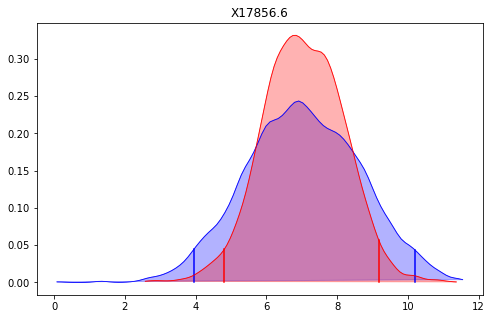

In [7]:
cl = 95

fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.set_title(labels[ii])

m,l,u = mykde(ex, cl=95, color='b', alpha=0.3, kernel='gaussian', bandwidth=0.2, ax=ax)
aw1 = u-l
m,l,u = mykde(im, Regarding Jennycl=95, color='r', alpha=0.3, kernel='gaussian', bandwidth=0.2, ax=ax)
aw2 = u-l
print(aw1,aw2)

### See the imputed data separatly

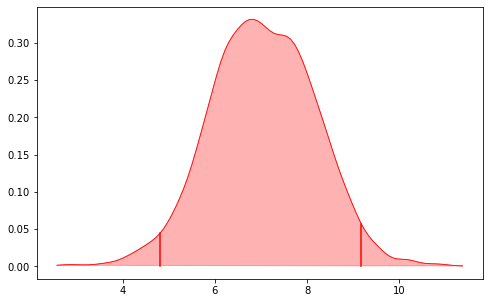

In [9]:
estimate = im

cl = 95

fig, ax = plt.subplots(1,1,figsize=(8,5))
m,l,u = mykde(estimate, cl=95, color='r', alpha=0.3, kernel='gaussian', bandwidth=0.2, ax=ax)
